In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

base_path = '/content/drive/MyDrive/x_ray_chest/results/yolo'
ver = 'v1'

# 新しいフォルダを生成
weight_folder = 'weight'
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'
test_img_folder = 'images'

weight_folder_path = os.path.join(base_path, ver, weight_folder)
train_folder_path = os.path.join(base_path, ver, train_folder)
test_folder_path = os.path.join(base_path, ver, test_folder)
val_folder_path = os.path.join(base_path, ver, val_folder)
test_img_path = os.path.join(base_path, ver, test_folder, test_img_folder)

In [3]:
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import h5py
import matplotlib.pyplot as plt
import cv2

In [4]:
def input_file_generator(weight_map_path):

    input_path = os.path.join(weight_map_path, 'input')
    result_path = os.path.join(weight_map_path, 'result')
    input_truth_path = os.path.join(input_path, 'truth')
    input_predict_path = os.path.join(input_path, 'predict')

    mkdir_path_list = [weight_map_path, input_path, result_path, input_truth_path, input_predict_path]

    for mkdir_path in mkdir_path_list:
        os.mkdir(mkdir_path)


    truth_files_path = glob('/content/drive/MyDrive/x_ray_chest/results/yolo/dataset/v1/labels/val/*')

    for truth_file_path in truth_files_path:

        file_name = os.path.basename(truth_file_path)

        column_name = ['label', 'center_x_per', 'center_y_per', 'width_per', 'height_per']

        data_df = pd.read_table(truth_file_path, names=column_name, sep=' ', encoding='utf_8', header=None)

        data_df['left'] = (data_df['center_x_per'] - (data_df['width_per'] / 2)) * 1024
        data_df['top'] = (data_df['center_y_per'] - (data_df['height_per'] / 2)) * 1024
        data_df['right'] = (data_df['center_x_per'] + (data_df['width_per'] / 2)) * 1024
        data_df['buttom'] = (data_df['center_y_per'] + (data_df['height_per'] / 2)) * 1024

        data_df = data_df.drop(['center_x_per', 'center_y_per', 'width_per', 'height_per'], axis=1)

        outdir_path = os.path.join(input_truth_path, file_name)

        data_df.to_csv(outdir_path, sep=' ', index=False, header=None, lineterminator='\n')


        outdir_path = os.path.join(input_predict_path, file_name)

        with open(outdir_path, 'w') as f:
            pass


    predict_base_path = os.path.join(val_folder_path, 'predict')
    epoch_name = os.path.basename(weight_map_path)

    predict_files_path = glob(os.path.join(predict_base_path, epoch_name, 'labels', '*'))

    for predict_file_path in predict_files_path:

        file_name = os.path.basename(predict_file_path)

        column_name = ['label', 'center_x_per', 'center_y_per', 'width_per', 'height_per', 'scores']

        data_df = pd.read_table(predict_file_path, names=column_name, sep=' ', encoding='utf_8', header=None)

        data_df['left'] = (data_df['center_x_per'] - (data_df['width_per'] / 2)) * 1024
        data_df['top'] = (data_df['center_y_per'] - (data_df['height_per'] / 2)) * 1024
        data_df['right'] = (data_df['center_x_per'] + (data_df['width_per'] / 2)) * 1024
        data_df['buttom'] = (data_df['center_y_per'] + (data_df['height_per'] / 2)) * 1024

        data_df = data_df.drop(['center_x_per', 'center_y_per', 'width_per', 'height_per'], axis=1)

        outdir_path = os.path.join(input_predict_path, file_name)

        data_df.to_csv(outdir_path, sep=' ', index=False, header=None, lineterminator='\n')


    sh_name = 'map.sh'
    with open(os.path.join(input_path, sh_name), 'w') as f:
        cmd1_row ='cd /content/drive/MyDrive/x_ray_chest/lib/map_tool'
        f.write(cmd1_row + '\n')
        cmd2_row = f'python pascalvoc.py -gt {input_truth_path} -det {input_predict_path} -gtformat xyrb -detformat xyrb -sp {result_path}'
        f.write(cmd2_row + '\n')



In [5]:
import random
import shutil
from PIL import Image, ImageDraw
import subprocess


map_path = os.path.join(val_folder_path, 'map')
os.mkdir(map_path)

weight_dirs = glob(os.path.join(weight_folder_path, 'epoch*'))

for weight_dir in weight_dirs:

    weight_name = os.path.splitext(os.path.basename(weight_dir))[0]
    weight_map_path = os.path.join(map_path, weight_name)

    input_file_generator(weight_map_path)

    os.chmod(os.path.join(weight_map_path, 'input', 'map.sh'), 0o700)

    os.chdir(os.path.join(weight_map_path, 'input'))
    subprocess.run(['bash', './map.sh'], text=True)


In [6]:
from glob import glob
import re
import pandas as pd
import os

def map_read(pathdir1):

    map_path = os.path.join(val_folder_path, 'map')

    epoch_list = []
    map_value_list = []


    entries = os.listdir(pathdir1)

    folder_count = 0
    for entry in entries:
        folder_count += 1

    print(folder_count)


    for i in range(folder_count):

        epoch = i + 1
        epoch_list.append(epoch)

        weight_dir = f'epoch{epoch}'
        result_file_path = os.path.join(map_path, weight_dir, 'result', 'results.txt')

        with open(result_file_path, 'r') as f:
            txt_data = f.read()
            pattern = 'mAP: (\d+\.\d+)%'
            map_value = re.findall(pattern, txt_data)
            map_value_list.append(float(map_value[0]))

    map_result_list = [epoch_list, map_value_list]
    map_result_df = pd.DataFrame(map_result_list, index=['epoch', 'map']).T

    map_result_df.to_csv(os.path.join(val_folder_path, 'map.csv'), columns=['epoch', 'map'])

    return map_result_df


200
     epoch   map
0      1.0  0.00
1      2.0  0.12
2      3.0  0.01
3      4.0  2.53
4      5.0  0.49
..     ...   ...
195  196.0  8.41
196  197.0  8.56
197  198.0  8.25
198  199.0  8.06
199  200.0  8.06

[200 rows x 2 columns]


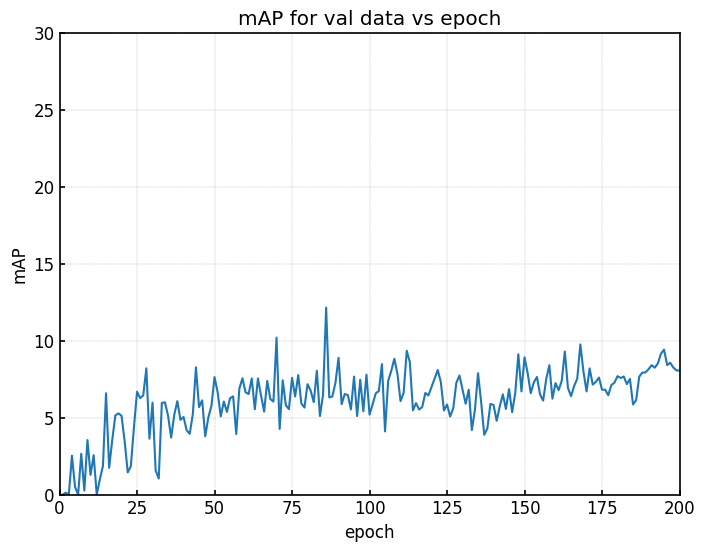

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

pathdir1 = '/content/drive/MyDrive/x_ray_chest/results/yolo/v1/val/map/'

map_result_df = map_read(pathdir1)

print(map_result_df)

plt.rcParams['font.family']= 'sans-serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=True
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 0.3
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(map_result_df['epoch'], map_result_df['map'])
ax.set_xlim(0, 200)
ax.set_ylim(0, 30)
ax.set_xlabel('epoch')
ax.set_ylabel('mAP')
ax.set_title('mAP for val data vs epoch')

plt.show()

